# Prepare Environment

Load necessary modules and attempt to compile the GrOpt library if it isn't already

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from timeit import default_timer as timer

# This attempts to re-compile the library in case it has been changed, mostly for debug, but won't do anything
# if nothing is changed
import subprocess
out = subprocess.run(["python", "setup.py", "build_ext", "--inplace"], stdout=subprocess.PIPE)
import gropt

from helper_utils import *

%matplotlib inline

# M0 Nulled CODE

Generate a waveform with $M_0 = 0$, other parameters as listed in the code.

TE was manually selected (44.4 ms) to hit b-value = 600

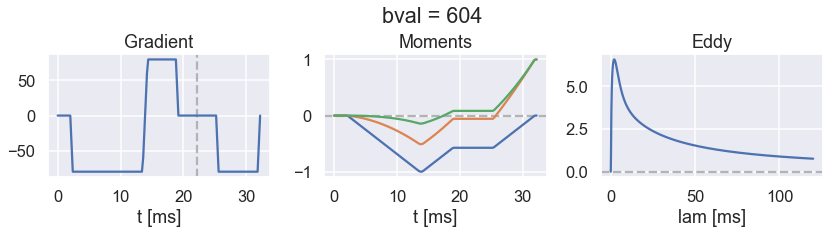

In [2]:
gmax = .08      # Gmax in [T/s]
smax = 200      # Slew max im [T/m/s]
MMT = 0         # MMT is the maximum order moment to null (0,1,2)
TE = 44.4       # TE in [ms]
T_readout = 12  # [ms]
T_90 = 2        # [ms]
T_180 = 6       # [ms]
diffmode = 2    # diffmode =1 for beta-max, =2 for b-val max
dt = 0.2e-3     # gradient raster time in [s]

G, dd = gropt.run_diffkernel_fixdt(gmax, smax, MMT, TE, T_readout, T_90, T_180, diffmode, dt=dt)
plot_waveform(G, TE, T_readout)

# M0+M1 Nulled CODE

Generate a waveform with $M_0 = 0$ and $M_1 = 0$, other parameters as listed in the code.

TE was manually selected (60 ms) to hit b-value = 600

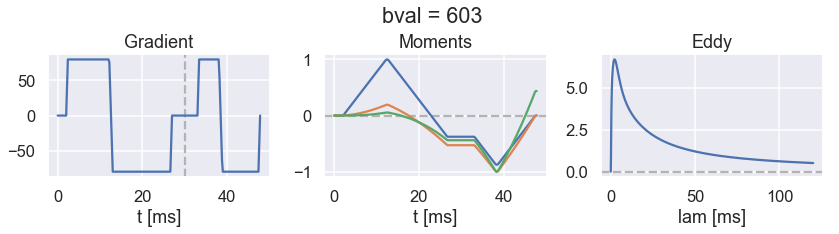

In [3]:
gmax = .08      # Gmax in [T/s]
smax = 200      # Slew max im [T/m/s]
MMT = 1         # MMT is the maximum order moment to null (0,1,2)
TE = 60         # TE in [ms]
T_readout = 12  # [ms]
T_90 = 2        # [ms]
T_180 = 6       # [ms]
diffmode = 2    # diffmode =1 for beta-max, =2 for b-val max
dt = 0.2e-3     # gradient raster time in [s]

G, dd = gropt.run_diffkernel_fixdt(gmax, smax, MMT, TE, T_readout, T_90, T_180, diffmode, dt=dt)
plot_waveform(G, TE, T_readout)

# M0+M1+M2 Nulled CODE

Generate a waveform with $M_0 = 0$, $M_1 = 0$ and $M_2 = 0$, other parameters as listed in the code.

TE was manually selected (71.5 ms) to hit b-value = 600

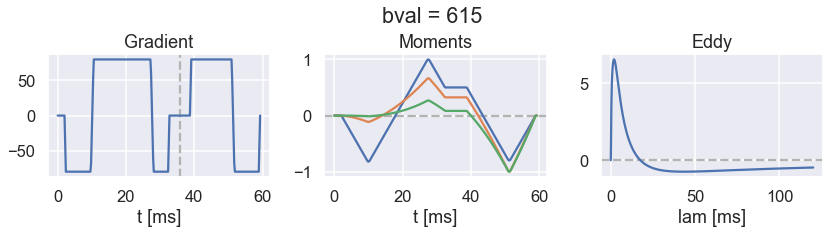

In [4]:
gmax = .08      # Gmax in [T/s]
smax = 200      # Slew max im [T/m/s]
MMT = 2         # MMT is the maximum order moment to null (0,1,2)
TE = 71.5         # TE in [ms]
T_readout = 12  # [ms]
T_90 = 2        # [ms]
T_180 = 6       # [ms]
diffmode = 2    # diffmode =1 for beta-max, =2 for b-val max
dt = 0.2e-3     # gradient raster time in [s]

G, dd = gropt.run_diffkernel_fixdt(gmax, smax, MMT, TE, T_readout, T_90, T_180, diffmode, dt=dt)
plot_waveform(G, TE, T_readout)

### Run the same waveform with slew max = 100 [T/m/s] and gmax = 40 [mT/m] and the same TE

Much lower bvalue (150 vs 600)

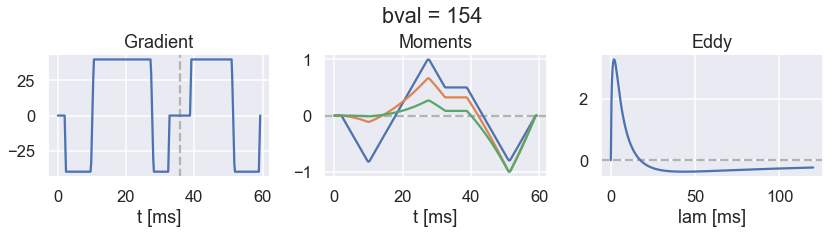

In [5]:
gmax = .04      # Gmax in [T/s]
smax = 100      # Slew max im [T/m/s]
MMT = 2         # MMT is the maximum order moment to null (0,1,2)
TE = 71.5       # TE in [ms]
T_readout = 12  # [ms]
T_90 = 2        # [ms]
T_180 = 6       # [ms]
diffmode = 2    # diffmode =1 for beta-max, =2 for b-val max
dt = 0.2e-3     # gradient raster time in [s]

G, dd = gropt.run_diffkernel_fixdt(gmax, smax, MMT, TE, T_readout, T_90, T_180, diffmode, dt=dt)
plot_waveform(G, TE, T_readout)

# Finding minimum TE

The code above all runs with a fixed TE, but ideally we would presribe the optimal b-value.

This function will do a bisecting line search on TE to find the shortest TE with b-value > prescribed b-value

In [6]:
def get_min_TE(b_value, gmax, smax, MMT, T_readout, T_90, T_180, diffmode, dt, min_TE = 0, max_TE = 200):
    
    # Make min TE equal to the dead-time +10ms
    if min_TE == 0:
        min_TE = T_readout + T_90 + T_180 + 10
    
    # b-value of min_TE
    min_G, dd = gropt.run_diffkernel_fixdt(gmax, smax, MMT, min_TE, T_readout, T_90, T_180, diffmode, dt=dt)
    min_b = get_bval(min_G, T_readout, dt)
    
    # b-value of max_TE
    max_G, dd = gropt.run_diffkernel_fixdt(gmax, smax, MMT, max_TE, T_readout, T_90, T_180, diffmode, dt=dt)
    max_b = get_bval(max_G, T_readout, dt)
    
    if max_b < b_value:
        print('ERROR: max_TE looks like its not big enough')
        
    while (max_TE - min_TE) >= 1e3*dt:
        # Solve for TE in between min and max TE
        bisect_TE = min_TE + (max_TE - min_TE)/2.0
        bisect_G, dd = gropt.run_diffkernel_fixdt(gmax, smax, MMT, bisect_TE, T_readout, T_90, T_180, diffmode, dt=dt)
        bisect_b = get_bval(bisect_G, T_readout, dt)
        
        if bisect_b > b_value:
            max_TE = bisect_TE
            max_b = bisect_b
            max_G = bisect_G
        else:
            min_TE = bisect_TE
            min_b = bisect_b
            min_G = bisect_G
            
    if min_b > b_value:
        return (min_G, min_TE, min_b)
    else:
        return (max_G, max_TE, max_b)


# Test get_min_TE

Test minimum TE finder for b-value = 350

Shortest waveform was TE = 63.2 ms with bvalue = 351.3


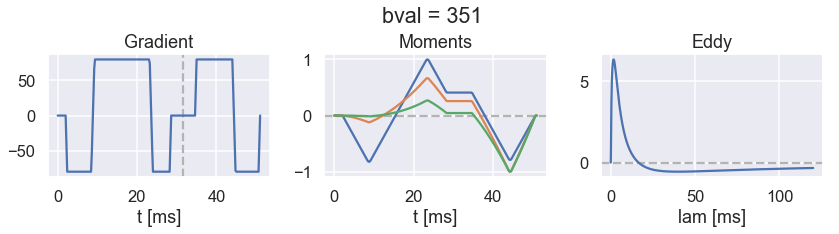

In [7]:
bval0 = 350     # Desired b-value
gmax = .08      # Gmax
smax = 200      # Slew max im [T/m/s]
MMT = 2         # MMT is the maximum order moment to null (0,1,2)
T_readout = 12  # [ms]
T_90 = 2        # [ms]
T_180 = 6       # [ms]
diffmode = 2    # diffmode =1 for beta-max, =2 for b-val max
dt = 0.2e-3     # gradient raster time in [s]



G, TE, bval = get_min_TE(bval0, gmax, smax, MMT, T_readout, T_90, T_180, diffmode, dt, min_TE = 0, max_TE = 200)
print('Shortest waveform was TE = %.1f ms with bvalue = %.1f' % (TE, bval))
plot_waveform(G, TE, T_readout)